# Dfsu - 2D interpolation
This notebook demonstrates how to interpolate dfsu data to a grid, how to save the gridded data as dfs2 and geotiff. It also shows how to interpolate dfsu data to another mesh. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

from mikeio import Dfsu, Mesh, Dfs2
from mikeio.spatial import Grid2D

In [2]:
dfs = Dfsu('../tests/testdata/wind_north_sea.dfsu')
ds = dfs.read(items=['Wind speed'])

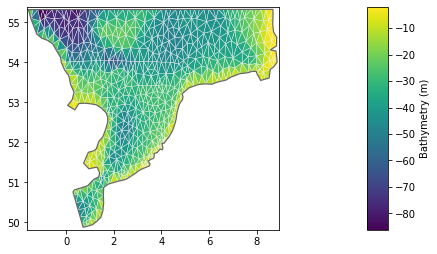

In [3]:
dfs.plot(figsize=(8,6));

# Understanding Grid2d
A Grid2d can be created either by giving x- and y-vectors, or by giving a bounding box and shape or spacing. The Grid2D can saved to mesh. 

In [4]:
x = np.linspace(0,10,6)
y = [0,1.0,2.0]
g = Grid2D(x,y)
g

<mikeio.Grid2D>
x-axis: nx=6 points from x0=0 to x1=10 with dx=2
y-axis: ny=3 points from y0=0 to y1=2 with dy=1
Number of grid points: 18

In [5]:
g.to_mesh('gridmesh.mesh')

<AxesSubplot:>

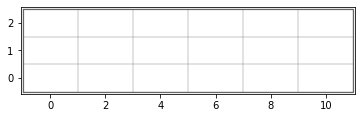

In [6]:
from mikeio import Mesh
Mesh('gridmesh.mesh').plot(plot_type='mesh_only')

# Interpolate to grid
1. Get an overset grid covering the domain with 50-by-40 grid cells.
2. Then get an interpolant consisting of the element ids and weights for these grid points.
3. Then interpolate all data to the new grid and plot. 
4. The interpolated data is then saved to a dfs2 file.

In [7]:
g = dfs.get_overset_grid(shape=(50,40))
g

<mikeio.Grid2D>
x-axis: nx=50 points from x0=-1.47424 to x1=8.74809 with dx=0.208619
y-axis: ny=40 points from y0=49.9408 to y1=55.259 with dy=0.136363
Number of grid points: 2000

In [8]:
g.bbox

BoundingBox(left=-1.5785510642197123, bottom=49.87266744109285, right=8.85240247077194, top=55.327192557197655)

In [9]:
g.x0

-1.4742415288697956

In [10]:
interpolant = dfs.get_2d_interpolant(g.xy, n_nearest=1)

In [11]:
dsi = dfs.interp2d(ds, *interpolant, shape=(g.ny, g.nx))
dsi

<mikeio.DataSet>
Dimensions: (6, 40, 50)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00
Items:
  0:  Wind speed <Wind speed> (meter per sec)

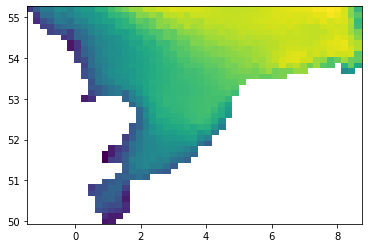

In [12]:
datgrid = dsi["Wind speed"][0]
plt.pcolormesh(g.xx, g.yy, datgrid);

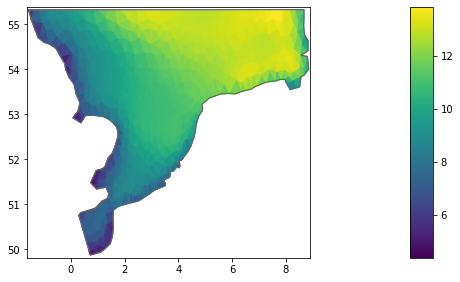

In [13]:
dat_orig = ds[0][0,:]
dfs.plot(dat_orig, show_mesh=False, figsize=(9,7));

## Save to GeoTiff

Install [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) by running this in a command prompt before running this notebook

`conda install -c conda-forge rasterio`

In [14]:
import rasterio
from rasterio.transform import from_origin
# Dcoumentation https://rasterio.readthedocs.io/en/latest/index.html

with rasterio.open(
     'wind.tif',
     'w',
     driver='GTiff',
     height=g.ny,
     width=g.nx,
     count=1,
     dtype=datgrid.dtype,
     crs='+proj=latlong',
     transform=from_origin(g.bbox.left, g.bbox.top, g.dx, g.dy)
     ) as dst:
        dst.write(np.flipud(datgrid), 1)
    

## Save to dfs2 file
Note: data needs to be flipped upside down

In [15]:
dsi.flipud()

<mikeio.DataSet>
Dimensions: (6, 40, 50)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00
Items:
  0:  Wind speed <Wind speed> (meter per sec)

In [16]:
dfs2_filename = 'wind_north_sea_interpolated.dfs2'
dfs2 = Dfs2()
coordinate = [dfs.projection_string, g.x0, g.y0, 0]
dfs2.write(dfs2_filename, data=dsi, coordinate=coordinate, dx=g.dx, dy=g.dy)

# Interpolate to other mesh
Interpolate the data from this coarse mesh onto a finer resolution mesh


In [17]:
msh = Mesh('../tests/testdata/north_sea_2.mesh')

In [18]:
dfs.n_elements, msh.n_elements  # new mesh has more elements

(958, 2259)

In [19]:
xy = msh.element_coordinates[:,:2]
interpolant = dfs.get_2d_interpolant(xy, n_nearest=4)

In [20]:
dsi = dfs.interp2d(ds, *interpolant)

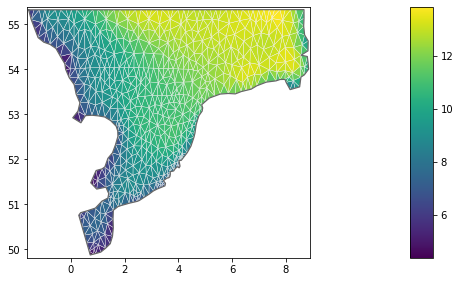

In [21]:
dat_orig = ds[0][0,:]
dfs.plot(dat_orig, figsize=(9,7));

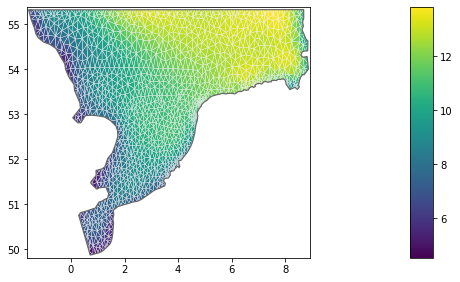

In [22]:
dat_interp = dsi[0][0,:]
msh.plot(dat_interp, figsize=(9,7));

### Note: 3 of the new elements are outside the original mesh and data are therefore NaN by default

In [23]:
nan_elements = msh.element_ids[np.isnan(dat_interp)]
nan_elements

array([ 249,  451, 1546])

In [24]:
dfs.contains(msh.element_coordinates[nan_elements,:2])

array([False, False, False])

### We can force extrapolation to avoid the NaN values

In [25]:
interpolant = dfs.get_2d_interpolant(xy, n_nearest=4, extrapolate=True)
dat_interp = dfs.interp2d(dat_orig, *interpolant)

In [26]:
n_nan_elements = sum(np.isnan(dat_interp))
n_nan_elements

0

# Clean up

In [27]:
import os

os.remove("wind_north_sea_interpolated.dfs2")
os.remove("gridmesh.mesh")
os.remove("wind.tif")